In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## 데이터 전처리

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# %cd /content/drive

Mounted at /content/drive


In [ ]:
file_path = '/content/drive/MyDrive/NEWDEAL/project/preprocessing/datasets/5_dog_breed_image_dataset/'

train_dir = os.path.join(file_path, 'train')
validation_dir = os.path.join(file_path, 'valid')
test_dir = os.path.join(file_path, 'test')

# 학습 데이터가 각 100개정도 뿐이니까 작게 잡음 (데이터는 적은데 Batch size 커지면 학습이 불안정해짐)
# 라벨 모드 기억 SparseCategoricalCrossentropy

BATCH_SIZE =16
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            label_mode = 'int')

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 label_mode = 'int')

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           shuffle=True,
                                                           batch_size=BATCH_SIZE,
                                                           image_size=IMG_SIZE,
                                                           label_mode = 'int')
test_dataset.class_names

Found 561 files belonging to 5 classes.
Found 50 files belonging to 5 classes.
Found 50 files belonging to 5 classes.


['1', '2', '3', '4', '5']

In [ ]:
import csv

def csv_to_dict(file_path):
  with open(file_path, mode = "r", encoding = "UTF-8") as f:
    data = csv.DictReader(f, fieldnames=["id", "label"])
    result = [row for row in data]
    return result

label_path = "/content/drive/MyDrive/NEWDEAL/project/preprocessing/datasets/5_dog_breed_image_dataset/labels.csv"
labels = csv_to_dict(label_path)
labels

[{'id': '1', 'label': '말티즈 '},
 {'id': '2', 'label': '푸들 '},
 {'id': '3', 'label': '웰시코기 '},
 {'id': '4', 'label': '비글 '},
 {'id': '5', 'label': '시베리안허스키'}]

In [ ]:
import pandas as pd

def csv_to_dict_with_pd(file_path):
    df = pd.read_csv( file_path, names = ["id", "label"])
    result = df.to_dict(orient='records')
    return result

# 예시 사용
label_path = "/content/drive/MyDrive/NEWDEAL/project/preprocessing/datasets/5_dog_breed_image_dataset/labels.csv"
labels_by_pd = csv_to_dict_with_pd(label_path)
labels_by_pd

[{'id': 1, 'label': '말티즈 '},
 {'id': 2, 'label': '푸들 '},
 {'id': 3, 'label': '웰시코기 '},
 {'id': 4, 'label': '비글 '},
 {'id': 5, 'label': '시베리안허스키'}]

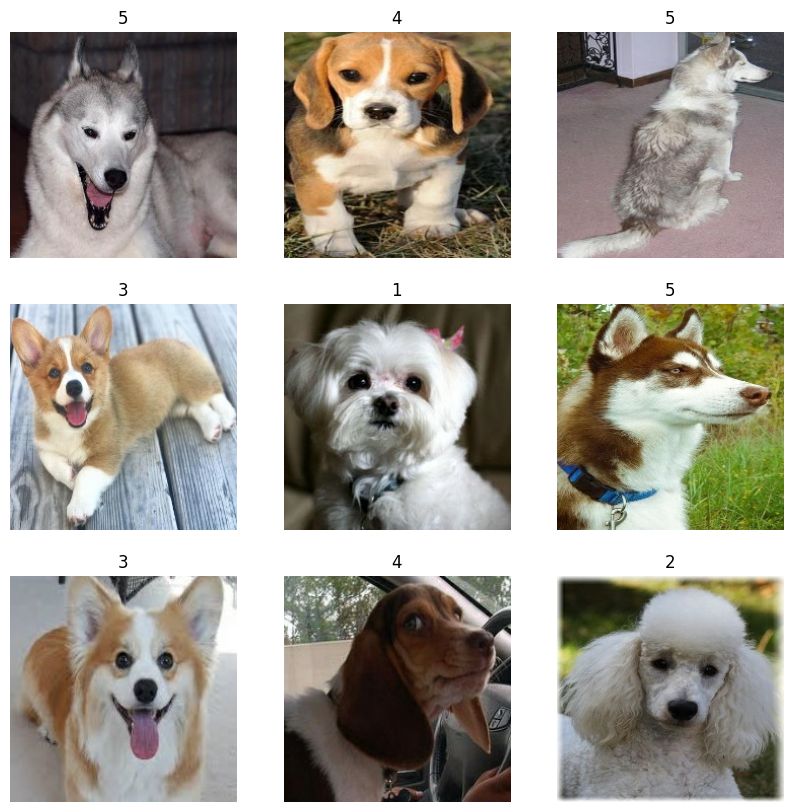

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 36
Number of validation batches: 4
Number of test batches: 4


In [ ]:
# 학습중 미리 데이터를 불러와서 버퍼링 없이 학습 할 수 있도록 함
# https://www.tensorflow.org/guide/data_performance?hl=ko

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# augmentation 데이터 증강 (나중에 flip rotation 외의 증강 있는지 찾아보기)

# 레이어가 플랫화 되지 않은것 같아서 class로 만들어서 get_config 넣음
class CustomDataAugmentation(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomDataAugmentation, self).__init__(**kwargs)
        self.flip = tf.keras.layers.RandomFlip('horizontal')
        self.rotate = tf.keras.layers.RandomRotation(0.2)

    def call(self, inputs, training = None):
        if training:
            inputs = self.flip(inputs)
            inputs = self.rotate(inputs)
        return inputs

    def get_config(self):
        config = super(CustomDataAugmentation, self).get_config()
        return config


data_augmentation = CustomDataAugmentation()

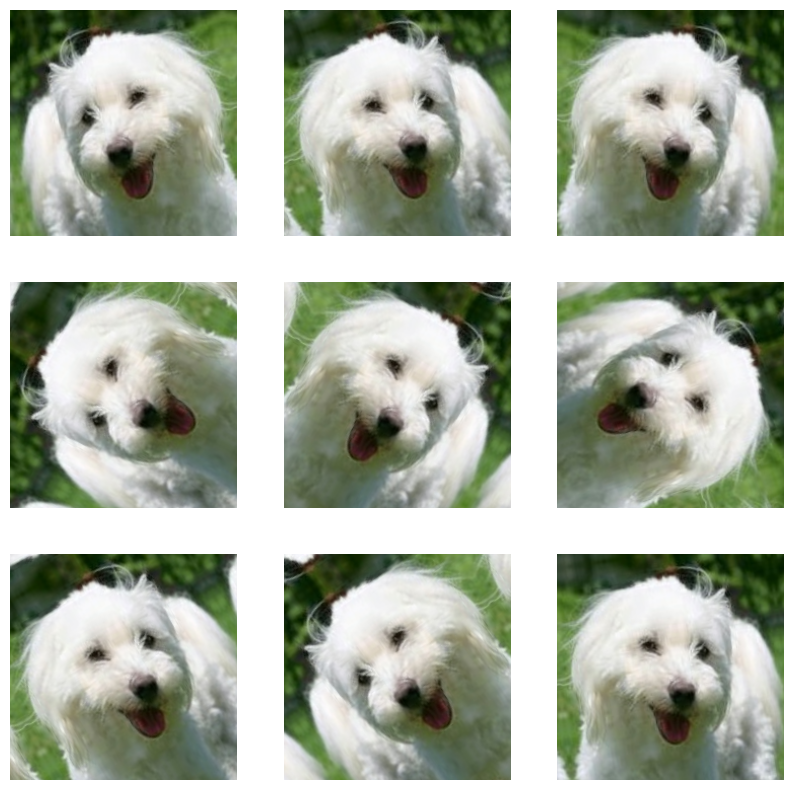

In [ ]:
# augmentation 된 이미지 출력

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training = True)
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
# tf 내장 모델의 경우 각 고유의 precess_input을 가지고 있음
preprocess_input = tf.keras.applications.vgg16.preprocess_input

In [ ]:
# include_top=False -> 원 모델의 맨 위 분류층을 포함하지 않도록 함 -> 학습하려는 데이터셋의 특징 추출에 유리

IMG_SHAPE = IMG_SIZE + (3,)

# 이렇게 가져오는거를 인스턴스화 한다고 표현
base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 7, 7, 512)


In [ ]:
# 기존 모델의 레이어 동결 - 가중치 업데이트 방지
base_model.trainable = False

In [ ]:
# 전이학습 base model에 BatchNormalization 레이어가 있는 경우 해당 레이어를 동결해 놓지 않으면 기존의 모델이 학습한 내용이 파괴된다고 함
# 기존 모델 전체 동결시 base_model.trainable = False,
# 기존 모델의 레이어를 건드릴때는 Training = False를 전달해야 기존 학습 유지 가능

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# 맨 위(위에 설계기준으로 마지막 층을 맨 위라고 함)에 분류를 위한 AveragePooling2D 추가
# 평균값으로 Pooling

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 512)


In [ ]:
# 배치당 최종 출력 shape

num_classes = 5
prediction_layer = tf.keras.layers.Dense(num_classes, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 5)


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
# x = preprocess_input(x)
x = tf.keras.layers.Lambda(lambda x: preprocess_input(x))(x) # 람다로 안 감싸면 .keras로 저장시 Elipsis 에러 뜸
x = base_model(x, training=False)  # 기존 모델에 BatchNormalization이 있기 때문에 training = False 넣어줌
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# 라벨이 정수 인코딩 -> SparseCategoricalCrossentropy 사용, softmax -> from_logits=False

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
              metrics=['accuracy'])

In [ ]:
model.summary() # sequential, slicingoplambda, bias 설명 봐도 잘 이해 안 됨 다시 볼 것

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 custom_data_augmentation (  (None, 224, 224, 3)       0         
 CustomDataAugmentation)                                         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables) # 위 모델을 돌렸을 때 학습 가능한 variables, 가중치와 편향을 의미

2

In [ ]:
# 초기 정확도 loss 확인
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

# 이니셜이 왜 이렇게 높게 나왔지..?

4/4 [==============================] - 2s 219ms/step - loss: 5.2712 - accuracy: 0.4400
initial loss: 5.27
initial accuracy: 0.44


In [ ]:
# 모델 학습
initial_epochs = 100

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
36/36 [==============================] - 13s 319ms/step - loss: 4.7437 - accuracy: 0.3797 - val_loss: 3.1596 - val_accuracy: 0.5200
Epoch 2/100
36/36 [==============================] - 11s 312ms/step - loss: 3.6414 - accuracy: 0.4938 - val_loss: 2.2835 - val_accuracy: 0.5800
Epoch 3/100
36/36 [==============================] - 12s 316ms/step - loss: 3.0163 - accuracy: 0.5205 - val_loss: 1.7797 - val_accuracy: 0.7000
Epoch 4/100
36/36 [==============================] - 12s 323ms/step - loss: 3.2670 - accuracy: 0.5152 - val_loss: 1.5162 - val_accuracy: 0.7400
Epoch 5/100
36/36 [==============================] - 12s 327ms/step - loss: 2.4658 - accuracy: 0.6043 - val_loss: 1.2908 - val_accuracy: 0.8200
Epoch 6/100
36/36 [==============================] - 12s 331ms/step - loss: 2.0796 - accuracy: 0.6399 - val_loss: 1.1582 - val_accuracy: 0.8400
Epoch 7/100
36/36 [==============================] - 12s 321ms/step - loss: 2.1655 - accuracy: 0.6310 - val_loss: 1.1108 - val_accuracy:

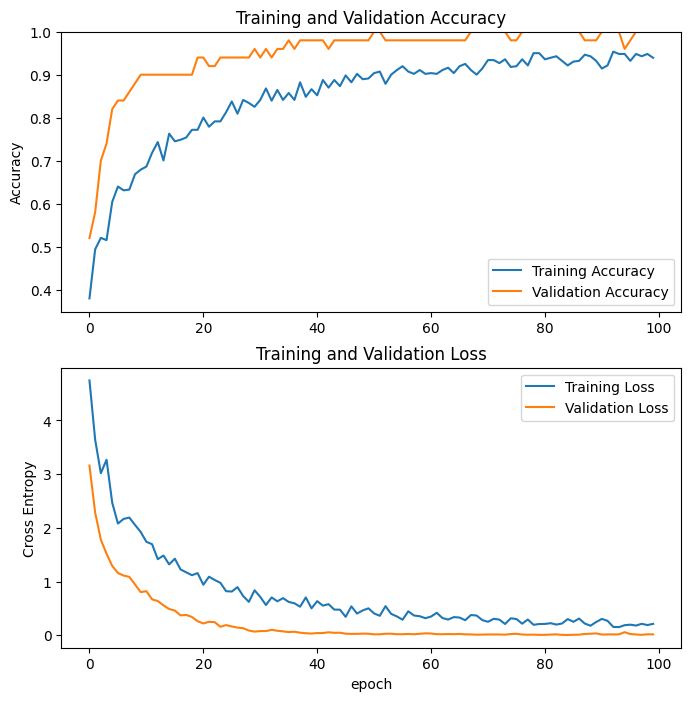

In [ ]:
# 학습 곡선

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
# 학습이 저장 되었는지 확인
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

4/4 [==============================] - 1s 219ms/step - loss: 0.0156 - accuracy: 1.0000
initial loss: 0.02
initial accuracy: 1.00


In [ ]:
# test

loss, accuracy = model.evaluate(test_dataset)
print("test loss:", loss)
print('Test accuracy :', accuracy)

4/4 [==============================] - 2s 221ms/step - loss: 0.0134 - accuracy: 1.0000
test loss: 0.013356507755815983
Test accuracy : 1.0


Predictions per class:
 [[0.14884758 0.14884758 0.14884758 0.40460968 0.14884758]
 [0.40460968 0.14884758 0.14884758 0.14884758 0.14884758]
 [0.40460968 0.14884758 0.14884758 0.14884758 0.14884758]
 [0.14884758 0.14884758 0.14884758 0.14884758 0.40460968]
 [0.40460965 0.1488476  0.14884761 0.1488476  0.1488476 ]
 [0.1488476  0.1488476  0.4046096  0.1488476  0.14884762]
 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]
 [0.14884758 0.14884758 0.40460968 0.14884758 0.14884758]
 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]
 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]
 [0.14884797 0.14884797 0.14884941 0.14884797 0.40460673]
 [0.14884758 0.14884758 0.40460968 0.14884758 0.14884758]
 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]
 [0.40460968 0.14884758 0.14884758 0.14884758 0.14884758]
 [0.14884786 0.14884786 0.1488489  0.14884786 0.4046075 ]
 [0.14884758 0.40460968 0.14884758 0.14884758 0.14884758]]
Predictions:
 [3 0 0 4 0 2 1 2 1 1 4 2 1 0 4 1]

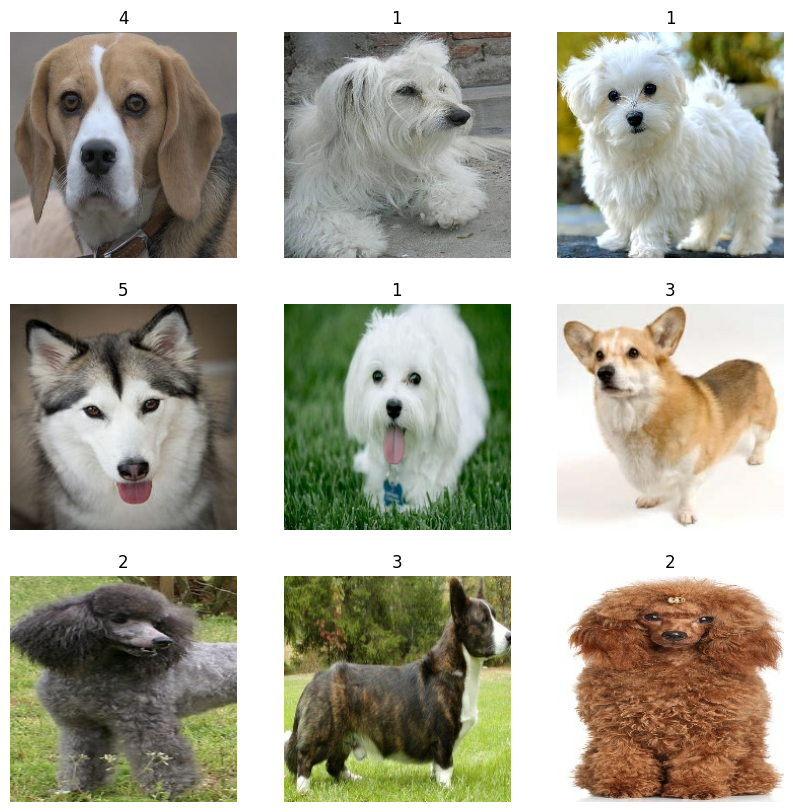

In [ ]:
# test image 전달
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

# softmax 함수로 return하도록 함
predictions_classes = tf.nn.softmax(predictions)
predictions = tf.argmax(predictions_classes, axis = 1)

print('Predictions per class:\n', predictions_classes.numpy())
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
# # 모델 가중치와 바이어스 출력
# for layer in model.layers:
#     print(layer.name, layer.get_weights())

In [ ]:
# model.get_config()

In [ ]:
try:
    model.save('/content/drive/MyDrive/NEWDEAL/project/model_1.keras')
    print("Model saved successfully.")
except Exception as e:
    print(f"Error saving model: {e}")

Model saved successfully.


<br/>
<br/>
<br/>
<br/>
<br/>

## **이 이하는 미세조정**
- 성능 향상 가능 But 데이터가 기존의 학습 데이터와 비슷한 경우에 권장되니까 여기서는 효과가 좋을지 알 수 없음

## 미세 조정

기능 추출 실험에서는 MobileNet V2 기본 모델을 기반으로 몇 개의 층 만 학습했습니다. 사전 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 **않았습니다**.

성능을 더욱 향상시키는 한 가지 방법은 추가 한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련(또는 "미세 조정")하는 것입니다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정됩니다.

Note: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 합니다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 됩니다.

또한 전체 MobileNet 모델이 아닌 소수의 최상위 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서 층이 높을수록 층이 더 전문화됩니다. 처음 몇 층은 거의 모든 유형의 이미지로 일반화되는 매우 간단하고 일반적인 특징을 학습합니다. 더 높은 수준으로 올라가면 훈련에 사용된 데이터 세트에 맞춰 특징이 점점 더 구체화 됩니다. 미세 조정의 목표는 이러한 전문화된 특징이 일반적인 학습을 덮어쓰지 않고 새 데이터셋에 맞춰 잘 동작 수 있도록 조정하는 것입니다.

### 최상위 층 고정 해제하기


base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [ ]:
base_model.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


### 모델 컴파일

훨씬 더 큰 모델을 훈련하고 있고 사전 훈련된 가중치를 다시 조정하려면 이 단계에서 낮은 학습률을 사용하는 것이 중요합니다. 그렇지 않으면 모델이 매우 빠르게 과대적합될 수 있습니다.

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 custom_data_augmentation (  (None, 224, 224, 3)       0         
 CustomDataAugmentation)                                         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [ ]:
len(model.trainable_variables)

2

### 모델 훈련 계속하기

이미 수렴 상태로 훈련된 경우에, 이 단계는 정확도를 몇 퍼센트 포인트 향상시킵니다.

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/110


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss
        return self.compiled_loss(
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2532, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5822, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 5) vs (None, 1)).


MobileNet V2 기본 모델의 마지막 몇 층을 미세 조정하고 그 위의 분류기를 훈련할 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다. 검증 손실은 훈련 손실보다 훨씬 높으므로 약간의 과적합이 나올 수 있습니다.

새로운 훈련용 데이터셋이 상대적으로 작고 원래 MobileNet V2의 데이터셋과 유사하기 때문에 약간의 과적합이 발생할 수 있습니다.


미세 조정 후 모델은 거의 98% 정확도에 도달합니다.

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 평가 및 예측

마지막으로 테스트 세트를 사용하여 새 데이터에 대한 모델의 성능을 확인할 수 있습니다.

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

이제 이 모델을 사용하여 애완 동물이 고양이인지 개인지 예측할 준비가 되었습니다.

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## 요약:

- **특징 추출을 위해 사전 훈련된 모델 사용하기**:  작은 데이터셋으로 작업 할 때는 동일한 범주의 클래스의 더 큰 데이터셋으로 훈련시킨 사전 학습된 모델의 특징을 활용하는 것이 일반적입니다. 사전 훈련된 모델을 인스턴스화하고 완전히 연결된 분류기를 맨 위에 추가하면 됩니다. 사전 훈련된 모델은 "고정"되고 분류기의 가중치만 훈련 중에 업데이트됩니다. 이 경우 컨벌루션 베이스 모델은 각 이미지와 관련된 모든 특징을 추출하며 주어진 추출된 특징을 가지고 이미지 클래스를 결정하는 분류기를 훈련합니다.

- **사전 훈련된 모델을 미세 조정하기**: 성능을 더욱 향상시키기 위해 사전 훈련된 모델의 최상위 계층을 미세 조정을 통해 새 데이터셋으로써 재사용 할 수 있습니다. 이 경우 모델이 주어진 데이터셋에 맞는 상위 레벨의 특징을 학습 할 수 있도록 가중치를 조정합니다. 이 기술은 일반적으로 훈련 데이터셋의 규모가 크고, 사전 훈련된 모델이 사용했던 원래 데이터셋과 매우 유사한 경우에 권장됩니다.

자세한 내용은 [전이 학습 가이드](https://www.tensorflow.org/guide/keras/transfer_learning)를 참조하십시오.
